In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train,n_test,num_inputs,batch_size = 20,10,200,5
true_w,true_b = torch.ones((num_inputs,1))* 0.01,0.05
# synthetic_data的作用：Generate y = Xw + b + noise
train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)
test_data  =d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(test_data,batch_size,is_train=False)

In [3]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))

    # torch.norm(w):计算w的l2范数
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.532723426818848


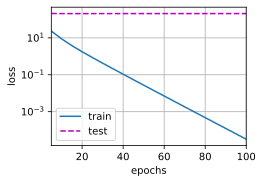

In [10]:
# 没有正则化，过拟合
train(lambd = 0)

w的L2范数是： 0.34697845578193665


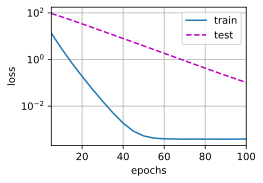

In [11]:
train(lambd=3)

In [12]:
# 简洁实现
def train_concise(wd):
    # 输入lambda
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        # 标准正态分布
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs,lr = 100,0.003
    trainer = torch.optim.SGD([
        # wd就是lambda
        {"params":net[0].weight,"weight_decay":wd},
        {"params":net[0].bias}],
        lr = lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X,y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X),y)
            l.backward()
            trainer.step()

        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                        (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.332793235778809


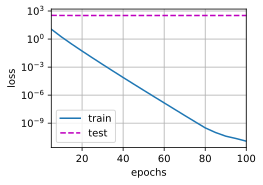

In [13]:
train_concise(0)

w的L2范数： 0.4080412983894348


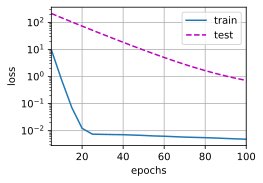

In [14]:
train_concise(3)